# Request Novoprolabs for sequence optimisation

In [1]:
from time import sleep
import json
from urllib.parse import urlencode
from urllib.request import Request, urlopen


class NovoPro:
    '''Get sequences from them.
    '''
    
    def __init__(self, seq):
        self.seq = seq
        self.url = 'https://www.novoprolabs.com/plus/ppc.php'
        self.post_obj = None
        self.json_object = None
        self.response_dict = None
        
    def make_req_obj(self):
        '''prepare request object for POST.
        '''
        post_field = {}
        post_field['sr'] = 'co'
        post_field['ez'] = ''
        post_field['sq'] = self.seq
        post_field['og'] = 'E.coli'
        post_field['st'] = 'DNA'
        
        self.post_obj = post_field
    
    def make_request(self):
        if self.post_obj is None:
            self.make_req_obj()
        request = Request(self.url, urlencode(self.post_obj).encode())
        self.json_object = urlopen(request).read().decode()
    
    def NovoProOptimised(self):
        if self.json_object is None:
            self.make_request()
        self.response_dict = json.loads(self.json_object)
        return self.response_dict[1][0]
            

In [2]:
import pandas as pd
import numpy as np
def progress(iteration, total, message=None):
    '''Simple progressbar
    '''
    if message is None:
        message = ''
    bars_string = int(float(iteration) / float(total) * 50.)
    print("\r|%-50s| %d%% (%s/%s) %s "% ('█'*bars_string+ "░" * \
                                     (50 - bars_string), float(iteration)/\
                                     float(total) * 100, iteration, total, \
                                     message), end='\r', flush=True)

    if iteration == total:
        print('\nCompleted!')
        

failed_seq = pd.read_csv('failed_all.csv')

In [3]:
failed_seq['NovoProRequest'] = failed_seq['Sequence'].apply(NovoPro)

In [37]:
#failed_seq['NovoProOprimised'] = failed_seq['NovoProRequest'].apply(lambda x: x.NovoProOptimised())

In [4]:
opt_seq = []

for ind, val in enumerate(failed_seq['NovoProRequest']):
    try:
        opt_seq.append(val.NovoProOptimised())
    except Exception as exp:
        print("Server returned incomplete message." , str(exp))
        #print("Sleeping for 1 mins.")
        #sleep(60)
        #print("Retrying...")
        opt_seq.append(np.nan)
    progress(ind, len(failed_seq))

Server returned incomplete message. HTTP Error 500: Internal Server Error
Server returned incomplete message. HTTP Error 500: Internal Server Error
Server returned incomplete message. HTTP Error 500: Internal Server Error
Server returned incomplete message. HTTP Error 500: Internal Server Error
Server returned incomplete message. HTTP Error 500: Internal Server Error
Server returned incomplete message. HTTP Error 500: Internal Server Error
Server returned incomplete message. HTTP Error 500: Internal Server Error
Server returned incomplete message. HTTP Error 500: Internal Server Error
Server returned incomplete message. HTTP Error 500: Internal Server Error
Server returned incomplete message. HTTP Error 500: Internal Server Error
Server returned incomplete message. HTTP Error 500: Internal Server Error
Server returned incomplete message. HTTP Error 500: Internal Server Error
Server returned incomplete message. HTTP Error 500: Internal Server Error
Server returned incomplete message. HT

In [28]:
failed_seq['NovoProOptimsed'] = opt_seq
failed_seq.to_csv('NovoOpt_sequences_only.csv', index=None)


# Accessibility

In [15]:
#Accessibility functions
import os
from multiprocessing import Pool, cpu_count
from subprocess import run, PIPE, DEVNULL
import secrets
import string
import tempfile


def accession_gen():
    '''Random accession numbers
    '''
    rand_string = ''.join(secrets.choice(string.ascii_uppercase + \
                                        string.digits) for _ in range(10))
    accession = '>' + rand_string + '\n'
    return accession, rand_string


def access_calc(seq, utr=None):
    '''Sequence accessibility
    '''
    tmp = os.path.join(tempfile.gettempdir(), 'plfold')
    
    nt_pos = 24 #the length to check accessibility values (30nt upstream)
    subseg_length = 48
    
    
    try:
        os.makedirs(tmp)
    except FileExistsError:
        pass
    if utr is None:
        utr = 'GGGGAATTGTGAGCGGATAACAATTCCCCTCTAGAAATAATTTTGTTTAACTTTAAGAAGGAGATATACAT'
    else:
        utr = utr.upper()
  
    sequence = utr + seq
    seq_accession, rand_string = accession_gen()
    input_seq = seq_accession + sequence
    run(['RNAplfold', '-W 210', '-u 50', '-O'], \
               stdout=PIPE, stderr=DEVNULL, input=input_seq, cwd=tmp, \
                encoding='utf-8')
    out1 = '/' + rand_string + '_openen'
    out2 = '/' + rand_string + '_dp.ps'
    #open_en = pd.read_csv(tmp+out1, sep='\t', skiprows=2, header=None)\
    #            .iloc[94][48] #for 0(ATG) to 13  nts to the left.

    open_en = pd.read_csv(tmp+out1, sep='\t', skiprows=2, header=None)\
                [subseg_length][len(utr) + nt_pos - 1] #-23 to 24 : row = len(utr)+24-1(because python starts from 0)
                                        #: column = 23+24+1 (region from 24nt to -23nt is free, \
                                            #for plfold, col# = nt to col#-1 free)
    os.remove(tmp+out1)
    os.remove(tmp+out2)
    return open_en



def parallelize_df(df, func):
    '''parallelizes operations on a dataframe by splitting it to chunks
    '''
    partitions = cpu_count()
    df_split = np.array_split(df, partitions)
    pool = Pool(partitions)
    results = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return results



def df_features(df, utr=None):
    df['Accessibility'] = df['Sequence'].apply(lambda x: access_calc(x, utr))
    df['Accessibility_N'] = df['NovoProOptimsed'].apply(lambda x: access_calc(x, utr) )
    return df



In [14]:
#parallelize_df(failed_seq, df_features)
failed_seq.dropna(inplace=True)


In [16]:
res_df = parallelize_df(failed_seq, df_features)

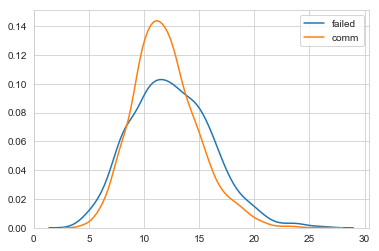

In [33]:
import seaborn as sns
sns.set_style("whitegrid")
sns.kdeplot(res_df['Accessibility'], label='failed')
sns.kdeplot(res_df['Accessibility_N'], label='comm')

In [24]:
res_df.to_csv('Novo_optimised.csv', index=None)

In [30]:
res_df.shape

(2573, 7)